# Sadə Kitab Tövsiyə Sistemi

In [81]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [82]:
books_df = pd.read_csv('Books.csv', sep=';', encoding='utf-8', 
                       names=['ISBN', 'Title', 'Author', 'Year', 'Publisher'],
                       header=None, low_memory=False)

In [83]:
books_df.head()

,ISBN,Title,Author,Year,Publisher
0,ISBN,Title,Author,Year,Publisher
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux


In [84]:
print("\nData set haqqında məlumat:")
print(f"Sətir sayı: {books_df.shape[0]}")
print(f"Sütun sayı: {books_df.shape[1]}")


Data set haqqında məlumat:
Sətir sayı: 271380
Sütun sayı: 5


In [85]:
print("\nSütunların tipləri:")
print(books_df.dtypes)


Sütunların tipləri:
ISBN         object
Title        object
Author       object
Year         object
Publisher    object
dtype: object


In [86]:
print("\nBoş dəyərlər:")
print(books_df.isnull().sum())


Boş dəyərlər:
ISBN         0
Title        0
Author       2
Year         0
Publisher    2
dtype: int64


## Data setin təmizlənməsi və hazırlanması


In [87]:
books_df['Year'] = pd.to_numeric(books_df['Year'], errors='coerce')

In [88]:
books_df.head()

,ISBN,Title,Author,Year,Publisher
0,ISBN,Title,Author,NaN,Publisher
1,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
2,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux


In [89]:
books_df = books_df.dropna()

In [90]:
print(books_df.isnull().sum())

ISBN         0
Title        0
Author       0
Year         0
Publisher    0
dtype: int64


Təkrarlanan kitabları yoxlayaq və təmizləyək

In [91]:
print(f"\nTəkrarlanan kitabların sayı: {books_df.duplicated(subset=['ISBN']).sum()}")
books_df = books_df.drop_duplicates(subset=['ISBN'])


Təkrarlanan kitabların sayı: 1


Müəllif adlarını standartlaşdıraq (BÖYÜK HƏRFLƏRİ normal formata çeviririk)

In [92]:
books_df['Author'] = books_df['Author'].apply(lambda x: x.title() if x.isupper() else x)

## Kitablar haqqında statistika


Ən məhşur müəlliflər (ən çox kitabı olan)

In [93]:
author_counts = books_df['Author'].value_counts()
top_authors = author_counts.head(10)

print("\nƏn məhşur 10 müəllif:")
for author, count in top_authors.items():
    print(f"{author}: {count} kitab")



Ən məhşur 10 müəllif:
Agatha Christie: 635 kitab
William Shakespeare: 570 kitab
Stephen King: 534 kitab
Ann M. Martin: 423 kitab
Francine Pascal: 420 kitab
Carolyn Keene: 373 kitab
Isaac Asimov: 344 kitab
Nora Roberts: 319 kitab
Barbara Cartland: 308 kitab
Charles Dickens: 307 kitab


İllərə görə kitab sayı

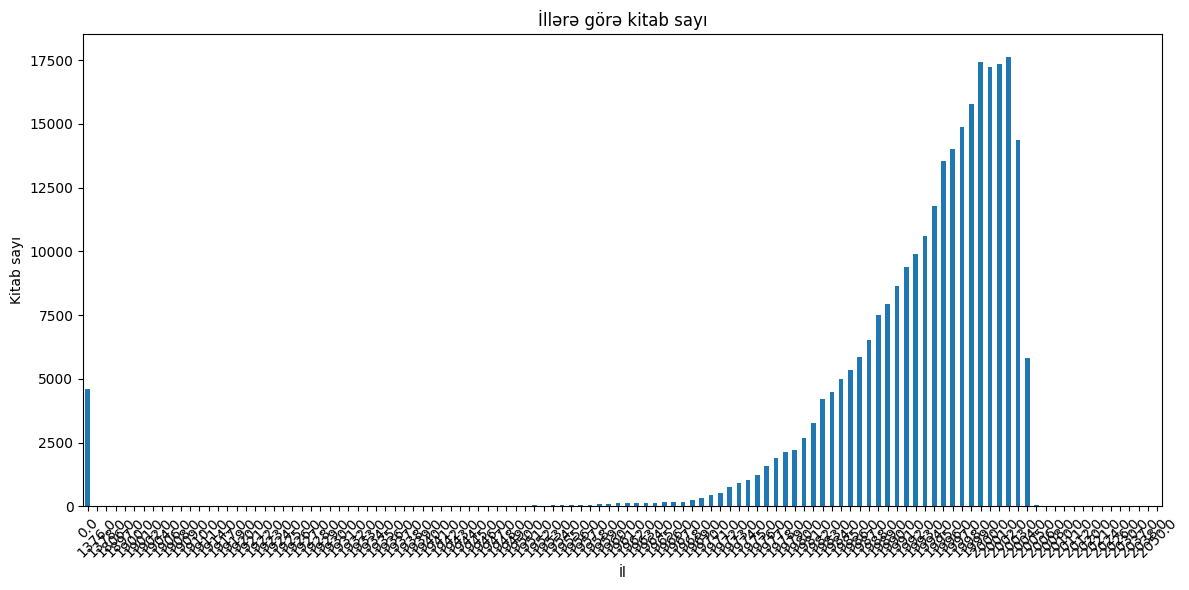

In [94]:
books_by_year = books_df['Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
books_by_year.plot(kind='bar')
plt.title('İllərə görə kitab sayı')
plt.xlabel('İl')
plt.ylabel('Kitab sayı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('books_by_year.png')
plt.show()


Nəşriyyatlara görə kitab sayı

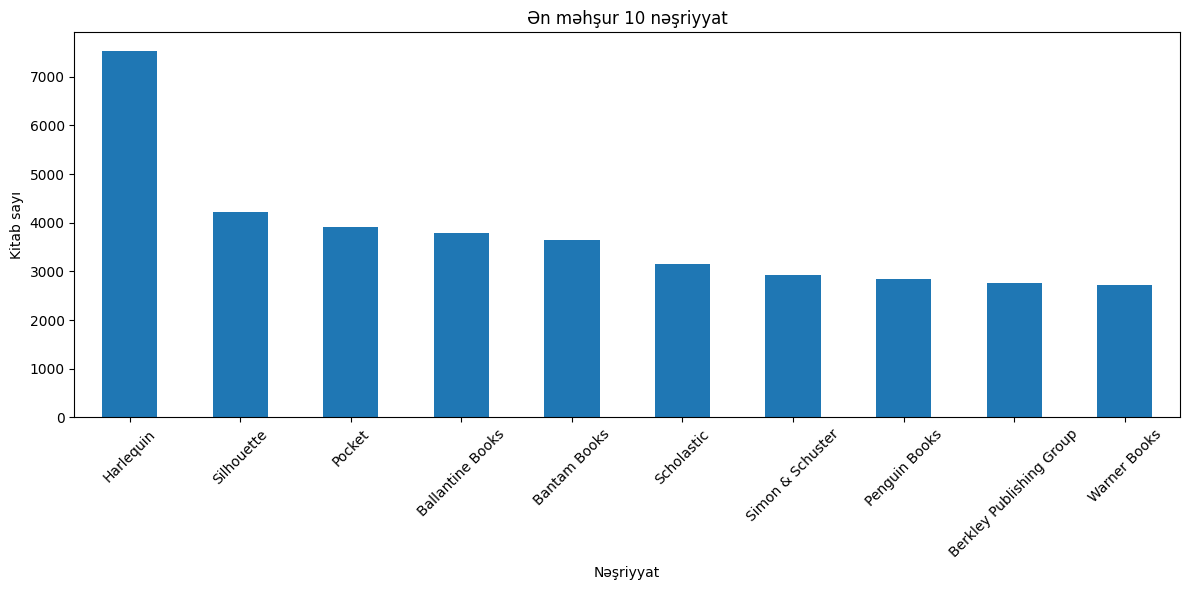

In [95]:
publisher_counts = books_df['Publisher'].value_counts().head(10)

plt.figure(figsize=(12, 6))
publisher_counts.plot(kind='bar')
plt.title('Ən məhşur 10 nəşriyyat')
plt.xlabel('Nəşriyyat')
plt.ylabel('Kitab sayı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_publishers.png')
plt.show()


## Məzmuna əsaslanan tövsiyə sistemi


In [96]:
# TF-IDF vektorizasiyası
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_df['Title'])

# Nearest Neighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [97]:

def get_content_based_recommendations(title, n=5):
    if title not in books_df['Title'].values:
        return "Kitab tapılmadı."
    idx = books_df[books_df['Title'] == title].index[0]
    tfidf_vector = tfidf_matrix[idx]
    distances, indices = nn_model.kneighbors(tfidf_vector, n_neighbors=n+1)
    recommended_indices = indices.flatten()[1:]  # Birincisi özü olur
    return books_df['Title'].iloc[recommended_indices].tolist()


In [98]:
print("\nMəzmuna əsaslanan tövsiyə nümunəsi:")
sample_book = books_df['Title'].iloc[1]
print(f"Seçilmiş kitab: {sample_book}")

content_recommendations = get_content_based_recommendations(sample_book)
print("\nBu kitaba oxşar kitablar:")
for i, rec in enumerate(content_recommendations, 1):
    print(f"{i}. {rec}")



Məzmuna əsaslanan tövsiyə nümunəsi:
Seçilmiş kitab: Clara Callan

Bu kitaba oxşar kitablar:
1. Decision
2. Decision
3. A Place in Normandy
4. Moments of Decision
5. Flavor of Normandy


Kitab indekslərini saxlayaq

In [99]:
indices = pd.Series(books_df.index, index=books_df['Title']).drop_duplicates()

## Tövsiyə funksiyaları


## Oxşar kitabların başlıq, müəllif, il və nəşriyyat məlumatları

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_df['Title'].fillna(''))

In [102]:
indices = pd.Series(books_df.index, index=books_df['Title']).drop_duplicates()

In [103]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [104]:
def get_content_based_recommendations(title, model=knn_model, books_df=books_df, indices=indices, tfidf_matrix=tfidf_matrix):
    try:
        idx = indices[title]
    except KeyError:
        return "Bu kitab data setdə tapılmadı."

    book_vector = tfidf_matrix[idx]
    distances, indices_knn = model.kneighbors(book_vector, n_neighbors=11)
    similar_indices = indices_knn.flatten()[1:]
    return books_df.iloc[similar_indices][['Title', 'Author', 'Year', 'Publisher']]

## Müəllifə görə tövsiyə sistemi


In [106]:
def get_author_recommendations(author_name, books_df=books_df):
    # Müəllifin kitablarını tapaq
    author_books = books_df[books_df['Author'].str.contains(author_name, case=False)]
    
    if author_books.empty:
        return "Bu müəllif data setdə tapılmadı."
    
    # Müəllifin kitablarını qaytaraq
    return author_books[['Title', 'Author', 'Year', 'Publisher']]


## Nəşriyyata görə tövsiyə sistemi


In [107]:
def get_publisher_recommendations(publisher_name, books_df=books_df):
    # Nəşriyyatın kitablarını tapaq
    publisher_books = books_df[books_df['Publisher'].str.contains(publisher_name, case=False)]
    
    if publisher_books.empty:
        return "Bu nəşriyyat data setdə tapılmadı."
    
    # Nəşriyyatın kitablarını qaytaraq
    return publisher_books[['Title', 'Author', 'Year', 'Publisher']]


## İlə görə tövsiyə sistemi


In [108]:
def get_year_recommendations(year, books_df=books_df):
    # Verilmiş ildə nəşr olunmuş kitabları tapaq
    year_books = books_df[books_df['Year'] == year]
    
    if year_books.empty:
        return f"{year} ilində nəşr olunmuş kitab tapılmadı."
    
    # İlin kitablarını qaytaraq
    return year_books[['Title', 'Author', 'Year', 'Publisher']]


## Tövsiyə nümunələri


## 1. Məzmuna əsaslanan tövsiyə nümunəsi

In [109]:
print("\nMəzmuna əsaslanan tövsiyə nümunəsi:")
sample_book = books_df['Title'].iloc[10]  # Təsadüfi bir kitab seçirik
print(f"Seçilmiş kitab: {sample_book}")

content_recommendations = get_content_based_recommendations(sample_book)
print("\nBu kitaba oxşar kitablar:")
print(content_recommendations)



Məzmuna əsaslanan tövsiyə nümunəsi:
Seçilmiş kitab: Nights Below Station Street

Bu kitaba oxşar kitablar:
                                           Title            Author    Year  \
79825   A Time for Anger: The Myth of Neutrality  Franky Schaeffer  1982.0   
122620                               The Bankers      Martin Mayer  1975.0   
130332          The Bankers: The Next Generation      Martin Mayer  1998.0   
236687                                    Hitler     Albert Marrin  1993.0   
243118                                   Hitler.   Marlis Steinert  1994.0   
241571                                    Hitler    Joachim C Fest  1975.0   
67394                                  Holocaust      Gerald Green  1978.0   
264193                       After the Holocaust  Howard Greenfeld  2001.0   
81760                              The Holocaust    Seymour Rossel  1981.0   
122510                          The Cry for Myth         Rollo May  1992.0   

               Publisher  
79825 

## 2. Müəllifə görə tövsiyə nümunəsi

In [110]:
print("\nMüəllifə görə tövsiyə nümunəsi:")
sample_author = books_df['Author'].iloc[15]  # Təsadüfi bir müəllif seçirik
print(f"Seçilmiş müəllif: {sample_author}")

author_recommendations = get_author_recommendations(sample_author)
print("\nBu müəllifin kitabları:")
print(author_recommendations)



Müəllifə görə tövsiyə nümunəsi:
Seçilmiş müəllif: Loren D. Estleman

Bu müəllifin kitabları:
                                                    Title             Author  \
16           The Witchfinder (Amos Walker Mystery Series)  Loren D. Estleman   
23314    Never Street (Amos Walker Mysteries (Paperback))  Loren D. Estleman   
24625                                      The Black Moon  Loren D. Estleman   
43075   Sweet Women Lie : An Amos Walker Mystery (Amos...  Loren D. Estleman   
50286                    Billy Gashade : An American Epic  Loren D. Estleman   
...                                                   ...                ...   
261137                                      Murdock's Law  Loren D. Estleman   
263088   Never Street (Amos Walker Mysteries (Hardcover))  Loren D. Estleman   
266782                                             Stress  Loren D. Estleman   
269785          The Witchfinder (Bookcassette(r) Edition)  Loren D. Estleman   
270680                    

## 3. Nəşriyyata görə tövsiyə nümunəsi

In [111]:
print("\nNəşriyyata görə tövsiyə nümunəsi:")
sample_publisher = books_df['Publisher'].iloc[20]  # Təsadüfi bir nəşriyyat seçirik
print(f"Seçilmiş nəşriyyat: {sample_publisher}")

publisher_recommendations = get_publisher_recommendations(sample_publisher)
print("\nBu nəşriyyatın kitabları:")
print(publisher_recommendations)



Nəşriyyata görə tövsiyə nümunəsi:
Seçilmiş nəşriyyat: Three Rivers Press

Bu nəşriyyatın kitabları:
                                                    Title  \
21      Our Dumb Century: The Onion Presents 100 Years...   
930              The Great Depression : America 1929-1941   
2072    Guenevere, Queen of the Summer Country (Guenev...   
3961    The Gentleman's Guide to Life : What Every Guy...   
3968                            Second Helpings : A Novel   
...                                                   ...   
266199  Clean Like a Man : Housekeeping for Men (and t...   
266402                          Lucrezia Borgia : A Novel   
268385  Fresh Start: Great Low-Fat Recipes, Day-By-Day...   
269007       The New York Times Manual of Style and Usage   
269462                                 Stress for Success   

                     Author    Year                Publisher  
21                The Onion  1999.0       Three Rivers Press  
930     Robert S. Mcelvaine  1993.0     

## 4. İlə görə tövsiyə nümunəsi

In [113]:
print("\nİlə görə tövsiyə nümunəsi:")
sample_year = int(books_df['Year'].iloc[25])  # Təsadüfi bir il seçirik
print(f"Seçilmiş il: {sample_year}")

year_recommendations = get_year_recommendations(sample_year)
print(f"\n{sample_year} ilində nəşr olunmuş kitablar:")
print(year_recommendations)




İlə görə tövsiyə nümunəsi:
Seçilmiş il: 1998

1998 ilində nəşr olunmuş kitablar:
                                                    Title              Author  \
15      A Second Chicken Soup for the Woman's Soul (Ch...       Jack Canfield   
16           The Witchfinder (Amos Walker Mystery Series)   Loren D. Estleman   
26                               Flood : Mississippi 1927       Kathleen Duey   
32                                        Chocolate Jesus   Stephan Jaramillo   
69              Heart of Darkness (Wordsworth Collection)       Joseph Conrad   
...                                                   ...                 ...   
271242                                    Robinson Crusoe        Daniel Defoe   
271257        Choose to Be Happy: Your Step-By-Step Guide      Wayne Froggatt   
271266  For Cause and Comrades: Why Men Fought in the ...  James M. McPherson   
271361  Introducing Nietzsche (Foundations in Children...       Laurence Gane   
271363  The Unified Modelin